## SIRモデルを使って、流行語を追ってみる

データは社内slackより。

- ws : 「ッス」が使われた割合
- ds : 「ッス」が生まれてからの経過日数


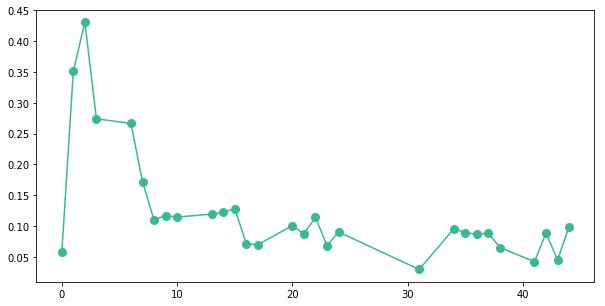

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import os 
from collections import defaultdict
import datetime
ws = [0.05695142378559464, 0.35154061624649857, 0.4304635761589404, 0.27389705882352944, 0.26649076517150394,
 0.17167381974248927, 0.10978520286396182, 0.1168091168091168, 0.11433756805807622, 0.11935483870967742,
 0.12195121951219512, 0.1282051282051282, 0.0712166172106825, 0.06941431670281996, 0.10069444444444445,
 0.08708708708708708, 0.1141552511415525, 0.06775700934579439, 0.09025270758122744, 0.029411764705882353,
 0.09523809523809523, 0.0893371757925072, 0.08641975308641975, 0.08860759493670886, 0.06496062992125984,
 0.04201680672268908, 0.08823529411764706, 0.04504504504504504, 0.09868421052631579]
ds = [0, 1, 2, 3, 6,
 7, 8, 9, 10, 13,
 14, 15, 16, 17, 20,
 21, 22, 23, 24, 31,
 34, 35, 36, 37, 38,
 41, 42, 43, 44]
plt.figure(figsize=(10,5))
plt.plot(ds,ws,"-o",label="su",color="#38BA91",markersize=8)

## 感染症モデルへの当てはめ

感染症モデルでは人を下記に分類

- $S(t)$ : 感染可能性のある人の数(Subjective)
- $I(t)$ : 感染者数(Infectious)
- $R(t)$ : 回復した人の数(Recovered)
- $E(t)$ : 潜伏期間中(Exposed)
- $N$ : 全人口(通常定数で、$N = S(t) + I(t) + R(t) + E(t)$

この組み合わせでモデル名が変わる。例えば潜伏期間がないものはSIRモデルを適用、あるものはSIERモデルを適用、などと言ったように変わる。1時間ごとに各値を更新する


(※数値計算は適当。Runge Kutta使ったほうがいいかも)

## optunaを入れてパラメータ推定

- alpha, beta, gammaを求める必要がある
- それぞれのパラメータをoptunaを用いて推定しよう
- 評価関数は二乗誤差を用いる

optunaセットアップ
```
pip install -U tqdm
pip install optuna
```

In [2]:
import optuna
import numpy as np
# 24時間にx軸をスケール変換
dt = 1
r = 24
t = int(ds[-1]*r/dt)
N = 1
def sir(ps, dt, beta, gamma):
    # SIRモデル
    S,I,R = ps
    dS = -beta*S*I
    dI = beta*S*I - gamma*I 
    dR = gamma*I
    return [dS*dt, dI*dt, dR*dt]

def objective(trial):
    alpha = trial.suggest_uniform("alpha",0.001,0.5)
    beta = trial.suggest_loguniform("beta", 0.01,1)
    gamma = trial.suggest_uniform("gamma",10**-5, 5*10**-1)
    i0 = ws[0] #infectous初期値
    ## モデルで数値計算
    dt = 1 
    ps = [N-i0-0.001,i0,0.001]
    Ss, Is, Rs = [ps[0]], [ps[1]], [ps[2]]
    for i in range(t):
        S, I, R = ps
        dS, dI, dR = sir(ps, dt, beta, gamma)
        S += dS
        I += dI
        R += dR
        Ss.append(S)
        Is.append(I)
        Rs.append(R)
        ps = [S, I, R]
    ## 誤差評価
    inds = [i*r for i in ds]
    diff = 0
    for ind, w in zip(inds,ws):
        x = Is[ind] + alpha*Rs[ind] #alphaの割合で定着する
        diff += abs(w-x)**2
    return (diff/len(inds))**0.5


### fitting
- optunaで決めたパラメータに従ってやってみる

In [3]:
study = optuna.create_study()
study.optimize(objective, n_trials=500)
study.best_params
res = study.best_params


[I 2020-05-23 17:30:17,856] Finished trial#0 with value: 0.12401390289247295 with parameters: {'alpha': 0.3259525031314649, 'beta': 0.175572894113007, 'gamma': 0.3058102221480349}. Best is trial#0 with value: 0.12401390289247295.
[I 2020-05-23 17:30:17,911] Finished trial#1 with value: 0.1020571341784311 with parameters: {'alpha': 0.4683664281048919, 'beta': 0.2522282040216172, 'gamma': 0.34403959405564327}. Best is trial#1 with value: 0.1020571341784311.
[I 2020-05-23 17:30:17,972] Finished trial#2 with value: 0.1516530674700179 with parameters: {'alpha': 0.023408467872729995, 'beta': 0.01553846692298412, 'gamma': 0.11808219720370886}. Best is trial#1 with value: 0.1020571341784311.
[I 2020-05-23 17:30:18,024] Finished trial#3 with value: 0.13288373799664527 with parameters: {'alpha': 0.4231016667239162, 'beta': 0.04168515393289791, 'gamma': 0.4693719720442088}. Best is trial#1 with value: 0.1020571341784311.
[I 2020-05-23 17:30:18,082] Finished trial#4 with value: 0.13942520781641463

[I 2020-05-23 17:30:19,897] Finished trial#35 with value: 0.13844057721005573 with parameters: {'alpha': 0.26694350683513857, 'beta': 0.17167943967099425, 'gamma': 0.07039403955066334}. Best is trial#33 with value: 0.07501781202044583.
[I 2020-05-23 17:30:19,962] Finished trial#36 with value: 0.09147635834460373 with parameters: {'alpha': 0.31469123005846533, 'beta': 0.1696313249172071, 'gamma': 0.15204073206471605}. Best is trial#33 with value: 0.07501781202044583.
[I 2020-05-23 17:30:20,025] Finished trial#37 with value: 0.08455451551528581 with parameters: {'alpha': 0.15388419021259503, 'beta': 0.39663510904333776, 'gamma': 0.04020658256585975}. Best is trial#33 with value: 0.07501781202044583.
[I 2020-05-23 17:30:20,095] Finished trial#38 with value: 0.07756921724118378 with parameters: {'alpha': 0.0919377629394657, 'beta': 0.26428780202625324, 'gamma': 0.09844178619720569}. Best is trial#33 with value: 0.07501781202044583.
[I 2020-05-23 17:30:20,172] Finished trial#39 with value: 

[I 2020-05-23 17:30:22,223] Finished trial#69 with value: 0.07071403721522163 with parameters: {'alpha': 0.16395462653278836, 'beta': 0.11979063891916071, 'gamma': 0.05549246411721231}. Best is trial#57 with value: 0.048757698379094494.
[I 2020-05-23 17:30:22,291] Finished trial#70 with value: 0.7273937963455454 with parameters: {'alpha': 0.13586631500103052, 'beta': 0.09038929198597202, 'gamma': 0.0003164234297106522}. Best is trial#57 with value: 0.048757698379094494.
[I 2020-05-23 17:30:22,362] Finished trial#71 with value: 0.03961869825364268 with parameters: {'alpha': 0.09616330690589253, 'beta': 0.14940856872519676, 'gamma': 0.033730398462688174}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:22,430] Finished trial#72 with value: 0.06575192900883804 with parameters: {'alpha': 0.1167544275053869, 'beta': 0.1497369217210855, 'gamma': 0.07066956680192062}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:22,496] Finished trial#73 with val

[I 2020-05-23 17:30:24,516] Finished trial#103 with value: 0.058566367019885414 with parameters: {'alpha': 0.05541805701560175, 'beta': 0.16645374983299818, 'gamma': 0.030053190840511043}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:24,581] Finished trial#104 with value: 0.12986550614180617 with parameters: {'alpha': 0.016459592859740746, 'beta': 0.12254821770975535, 'gamma': 0.08772978147626806}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:24,650] Finished trial#105 with value: 0.07146167367790615 with parameters: {'alpha': 0.09664926191870682, 'beta': 0.15522784316354987, 'gamma': 0.01672027513445876}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:24,714] Finished trial#106 with value: 0.05435252291540461 with parameters: {'alpha': 0.07631429648891944, 'beta': 0.10733312478618671, 'gamma': 0.03716296414560049}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:24,782] Finished trial#107 wi

[I 2020-05-23 17:30:26,877] Finished trial#137 with value: 0.10114963673180243 with parameters: {'alpha': 0.025739486630779407, 'beta': 0.15007096218098687, 'gamma': 0.06540698214212777}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:26,948] Finished trial#138 with value: 0.06921248867034316 with parameters: {'alpha': 0.0875698952533952, 'beta': 0.08928719895705112, 'gamma': 0.041726825484848865}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:27,021] Finished trial#139 with value: 0.12417839377149692 with parameters: {'alpha': 0.06724082631592153, 'beta': 0.10393835221543063, 'gamma': 0.09098529523552026}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:27,087] Finished trial#140 with value: 0.061108977865497696 with parameters: {'alpha': 0.10374821793001919, 'beta': 0.19933932771762028, 'gamma': 0.02789164109150546}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:27,162] Finished trial#141 wit

[I 2020-05-23 17:30:29,283] Finished trial#171 with value: 0.048358956524856195 with parameters: {'alpha': 0.08638277029169163, 'beta': 0.11608511172960581, 'gamma': 0.03823091601897946}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:29,360] Finished trial#172 with value: 0.04749484572153063 with parameters: {'alpha': 0.08557656952057281, 'beta': 0.11454299747648203, 'gamma': 0.036702639695213216}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:29,435] Finished trial#173 with value: 0.054603159687651656 with parameters: {'alpha': 0.08876949083809872, 'beta': 0.09253508442898754, 'gamma': 0.03408812740295146}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:29,507] Finished trial#174 with value: 0.05525471645964934 with parameters: {'alpha': 0.09971197316892161, 'beta': 0.10774022607886334, 'gamma': 0.01932659107162336}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:29,585] Finished trial#175 wi

[I 2020-05-23 17:30:32,071] Finished trial#205 with value: 0.05169233500764028 with parameters: {'alpha': 0.0950363702125225, 'beta': 0.07726153959700575, 'gamma': 0.02388071676468243}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:32,152] Finished trial#206 with value: 0.07018183308454339 with parameters: {'alpha': 0.07720419736760442, 'beta': 0.10084104622274181, 'gamma': 0.01422002433223218}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:32,231] Finished trial#207 with value: 0.041802781754634706 with parameters: {'alpha': 0.0934411070551864, 'beta': 0.11477749848513072, 'gamma': 0.027698613281141954}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:32,308] Finished trial#208 with value: 0.042663476652192465 with parameters: {'alpha': 0.10481770225407404, 'beta': 0.11322313154708713, 'gamma': 0.030608405449563718}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:32,387] Finished trial#209 wit

[I 2020-05-23 17:30:34,714] Finished trial#239 with value: 0.039721730366399664 with parameters: {'alpha': 0.09494196074515056, 'beta': 0.12868088199773617, 'gamma': 0.030074384539328945}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:34,792] Finished trial#240 with value: 0.05405700463703927 with parameters: {'alpha': 0.11195976634837464, 'beta': 0.12883486097798427, 'gamma': 0.05103127463960277}. Best is trial#71 with value: 0.03961869825364268.
[I 2020-05-23 17:30:34,872] Finished trial#241 with value: 0.03960470233357841 with parameters: {'alpha': 0.09462297216754159, 'beta': 0.133955922650814, 'gamma': 0.030038425118267043}. Best is trial#241 with value: 0.03960470233357841.
[I 2020-05-23 17:30:34,959] Finished trial#242 with value: 0.03938726527822367 with parameters: {'alpha': 0.09312279292200874, 'beta': 0.13353296050734645, 'gamma': 0.033388926929871554}. Best is trial#242 with value: 0.03938726527822367.
[I 2020-05-23 17:30:35,034] Finished trial#243 w

[I 2020-05-23 17:30:37,193] Finished trial#273 with value: 0.048738037595624166 with parameters: {'alpha': 0.08971674262620857, 'beta': 0.13806116832312879, 'gamma': 0.045756276891573355}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:37,267] Finished trial#274 with value: 0.053415252914465444 with parameters: {'alpha': 0.11421499080854886, 'beta': 0.15253220588983338, 'gamma': 0.05711134953887742}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:37,349] Finished trial#275 with value: 0.06605061296790965 with parameters: {'alpha': 0.09987519967834353, 'beta': 0.12816026741978376, 'gamma': 0.01690642161534348}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:37,428] Finished trial#276 with value: 0.04258166199333542 with parameters: {'alpha': 0.09126968015758012, 'beta': 0.12093308323469078, 'gamma': 0.03505390807799131}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:37,512] Finished trial#27

[I 2020-05-23 17:30:39,713] Finished trial#307 with value: 0.05308055971717655 with parameters: {'alpha': 0.07963857776421276, 'beta': 0.1255346293058823, 'gamma': 0.04325019682319054}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:39,781] Finished trial#308 with value: 0.0833088313395631 with parameters: {'alpha': 0.09750812333498408, 'beta': 0.11500942345231273, 'gamma': 0.06706579652929048}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:39,850] Finished trial#309 with value: 0.05134434052377934 with parameters: {'alpha': 0.08997148699014021, 'beta': 0.12722587268510438, 'gamma': 0.02078617569048796}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:39,923] Finished trial#310 with value: 0.3073189492892432 with parameters: {'alpha': 0.10400429415518436, 'beta': 0.1805842742213956, 'gamma': 0.0030157658652259396}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:39,994] Finished trial#311 wit

[I 2020-05-23 17:30:42,152] Finished trial#341 with value: 0.049222645567139144 with parameters: {'alpha': 0.0933643113306169, 'beta': 0.14233631398974012, 'gamma': 0.02285613706426909}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:42,228] Finished trial#342 with value: 0.24146325708305283 with parameters: {'alpha': 0.3673824651785481, 'beta': 0.12804619112338084, 'gamma': 0.04026013748935767}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:42,308] Finished trial#343 with value: 0.21298097702369512 with parameters: {'alpha': 0.331602434043502, 'beta': 0.09977221920354928, 'gamma': 0.031245878707703675}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:42,385] Finished trial#344 with value: 0.1326616593287171 with parameters: {'alpha': 0.11018438827175393, 'beta': 0.12181814548158859, 'gamma': 0.00865927250472956}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:42,457] Finished trial#345 with

[I 2020-05-23 17:30:44,685] Finished trial#375 with value: 0.12243900814430345 with parameters: {'alpha': 0.09784794333671379, 'beta': 0.14011029011445228, 'gamma': 0.13027266318462327}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:44,757] Finished trial#376 with value: 0.04671819594300356 with parameters: {'alpha': 0.12022097881389723, 'beta': 0.15692387193153867, 'gamma': 0.03281612582882959}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:44,827] Finished trial#377 with value: 0.08331640572068252 with parameters: {'alpha': 0.1835474763813791, 'beta': 0.12029437287300176, 'gamma': 0.04128465465910665}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:44,895] Finished trial#378 with value: 0.4227470309056831 with parameters: {'alpha': 0.4988170211043892, 'beta': 0.10257335076262936, 'gamma': 0.008427347219541328}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:44,968] Finished trial#379 wit

[I 2020-05-23 17:30:47,110] Finished trial#409 with value: 0.04470585521406047 with parameters: {'alpha': 0.11012367437017115, 'beta': 0.14035956080429227, 'gamma': 0.04441609865562709}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:47,185] Finished trial#410 with value: 0.06499471995244632 with parameters: {'alpha': 0.09627157844829841, 'beta': 0.16360438941775757, 'gamma': 0.06929735869738587}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:47,252] Finished trial#411 with value: 0.05411014934186508 with parameters: {'alpha': 0.05453488167349406, 'beta': 0.12891852159972075, 'gamma': 0.026705708034160183}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:47,316] Finished trial#412 with value: 0.5667218890672063 with parameters: {'alpha': 0.07141667636266158, 'beta': 0.11442796460832247, 'gamma': 0.0008348984073506607}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:47,386] Finished trial#413

[I 2020-05-23 17:30:49,582] Finished trial#443 with value: 0.08797483815327628 with parameters: {'alpha': 0.08804801187509782, 'beta': 0.11798426535609782, 'gamma': 0.012151225715383036}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:49,658] Finished trial#444 with value: 0.0685544072463108 with parameters: {'alpha': 0.10168638265721118, 'beta': 0.6960243876687421, 'gamma': 0.05237861127347434}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:49,734] Finished trial#445 with value: 0.042494921633411856 with parameters: {'alpha': 0.11546425614501515, 'beta': 0.13287741666511155, 'gamma': 0.03578884419651526}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:49,822] Finished trial#446 with value: 0.06586271540906133 with parameters: {'alpha': 0.1412316261095944, 'beta': 0.10756076515973484, 'gamma': 0.023935284054789164}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:49,902] Finished trial#447 w

[I 2020-05-23 17:30:52,131] Finished trial#477 with value: 0.0725285512476934 with parameters: {'alpha': 0.10090671421555741, 'beta': 0.17290517255911345, 'gamma': 0.018171537404923537}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:52,209] Finished trial#478 with value: 0.04884127250222218 with parameters: {'alpha': 0.1140761164703867, 'beta': 0.12037281990676765, 'gamma': 0.0425771548390434}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:52,305] Finished trial#479 with value: 0.1427913915007277 with parameters: {'alpha': 0.09148396613978378, 'beta': 0.1539272322080308, 'gamma': 0.23365906053185503}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:52,398] Finished trial#480 with value: 0.05502991915213951 with parameters: {'alpha': 0.13318112404922133, 'beta': 0.10960034676835527, 'gamma': 0.029106487859272404}. Best is trial#246 with value: 0.03927160142514411.
[I 2020-05-23 17:30:52,485] Finished trial#481 with

## 描画
実測値とfitting結果を突合させてみる


best params {'alpha': 0.09318250454664259, 'beta': 0.1346400021349427, 'gamma': 0.03315397909769168}
mininum error 0.03927160142514411


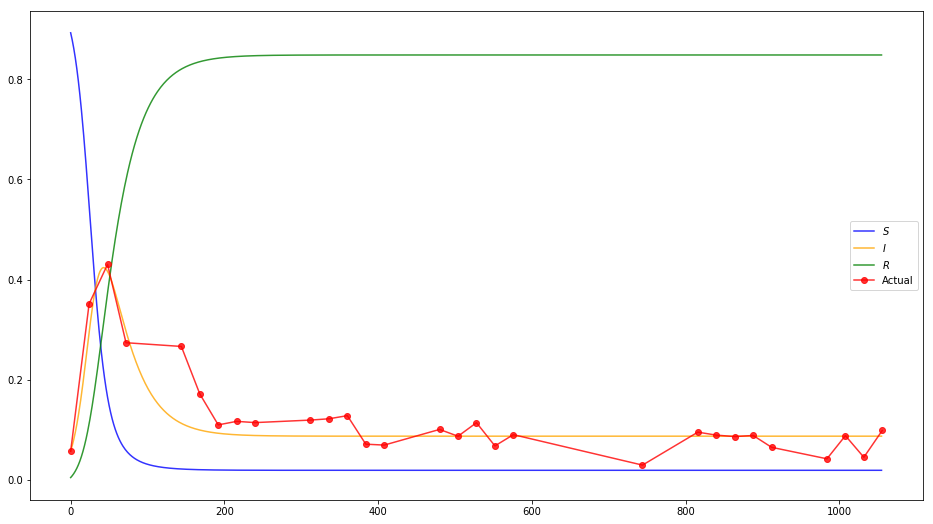

In [4]:
alpha = res["alpha"]
beta = res["beta"]
gamma = res["gamma"]
# i0 = res["i0"] #infectous初期値
i0 = ws[0]
ps = [N-i0-0.05,i0,0.005]
Ss, Is, Rs = [ps[0]], [ps[1]], [ps[2]]
for i in range(t-1):
    S, I, R = ps
    dS, dI, dR = sir(ps, dt, beta, gamma)
    S += dS
    I += dI
    R += dR
    Ss.append(S)
    Is.append(I)
    Rs.append(R)
    ps = [S, I, R]


Is = [i+alpha*r for i,r in zip(Is,Rs)]
Rs = [(1-alpha)*r for r in Rs]
plt.figure(figsize=(16,9))
plt.plot([i*dt for i in range(t)],Ss,label="$S$",color="blue",alpha=0.8)
plt.plot([i*dt for i in range(t)],Is,label="$I$",color="orange",alpha=0.8)
plt.plot([i*dt for i in range(t)],Rs,label="$R$",color="green",alpha=0.8)
plt.plot([i*r for i in ds],ws,"o-",label="Actual",color="red",alpha=0.8)
plt.legend()
print("best params", study.best_params)
print("mininum error",study.best_value)